In [111]:
%pylab inline
import tensorflow as tf
import numpy as np
import DifferentiableHOS as DHOS
import flowpm
import flowpm.raytracing as raytracing
import pickle
import flowpm.tfpower as tfpower
import flowpm.scipy.interpolate as interpolate
from absl import app
from flowpm.tfpower import linear_matter_power
import astropy.units as u
from itertools import cycle
import tensorflow_addons as tfa
import jax
import jax_cosmo as jc
from DifferentiableHOS.pk import pk as pkl
import jax_cosmo.power as power

Populating the interactive namespace from numpy and matplotlib


/usr/common/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['power']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [112]:
box_size=100.     # Transverse comoving size of the simulation volume
nc = 128           # Number of transverse voxels in the simulation volume
field_size = 5.   # Size of the lensing field in degrees
field_npix = 512  # Number of pixels in the lensing field
batch_size = 1    # Number of simulations to run in parallel
Omega_c=0.2589
sigma8=0.8159
nsteps=21

In [113]:
@tf.function
def compute_kappa(Omega_c, sigma8):
    """ Computes a convergence map using ray-tracing through an N-body for a given
    set of cosmological parameters
    """
    # Instantiates a cosmology with desired parameters
    cosmology = flowpm.cosmology.Planck15(Omega_c=Omega_c, sigma8=sigma8)

    # Then one step per lens plane
    stages = np.linspace(0.1, 1., nsteps, endpoint=True)


    # Create some initial conditions
    k = tf.constant(np.logspace(-4, 1, 128), dtype=tf.float32)
    pk = linear_matter_power(cosmology, k)
    pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)
    initial_conditions = flowpm.linear_field(
          [nc, nc, nc],
          [box_size, box_size, box_size],
          pk_fun,
          batch_size=1)
    initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)
    

    # Run the Nbody
    states = flowpm.nbody(cosmology,
                            initial_state,
                        stages, [nc, nc, nc],
                        return_intermediate_states=True)

    return  states,stages, initial_conditions

In [114]:
final_state, stages, initial_conditions =compute_kappa(Omega_c, sigma8)

In [115]:
cosmo=jc.Planck15()
nz =jc.redshift.delta_nz(0.92)
probes = [jc.probes.WeakLensing([nz])] 

In [131]:
pk_array=[]
pk_jax=[]
for i in range(len(stages)-1):
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[i][1][0])
    final_field=tf.reshape(final_field, [nc, nc, nc])
    k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                            box_size]),kmin=0.1,dk=2*np.pi/box_size)
    pk_array.append(power_spectrum)
    pk_jax.append(power.nonlinear_matter_power(cosmo, k, final_state[i][0]))

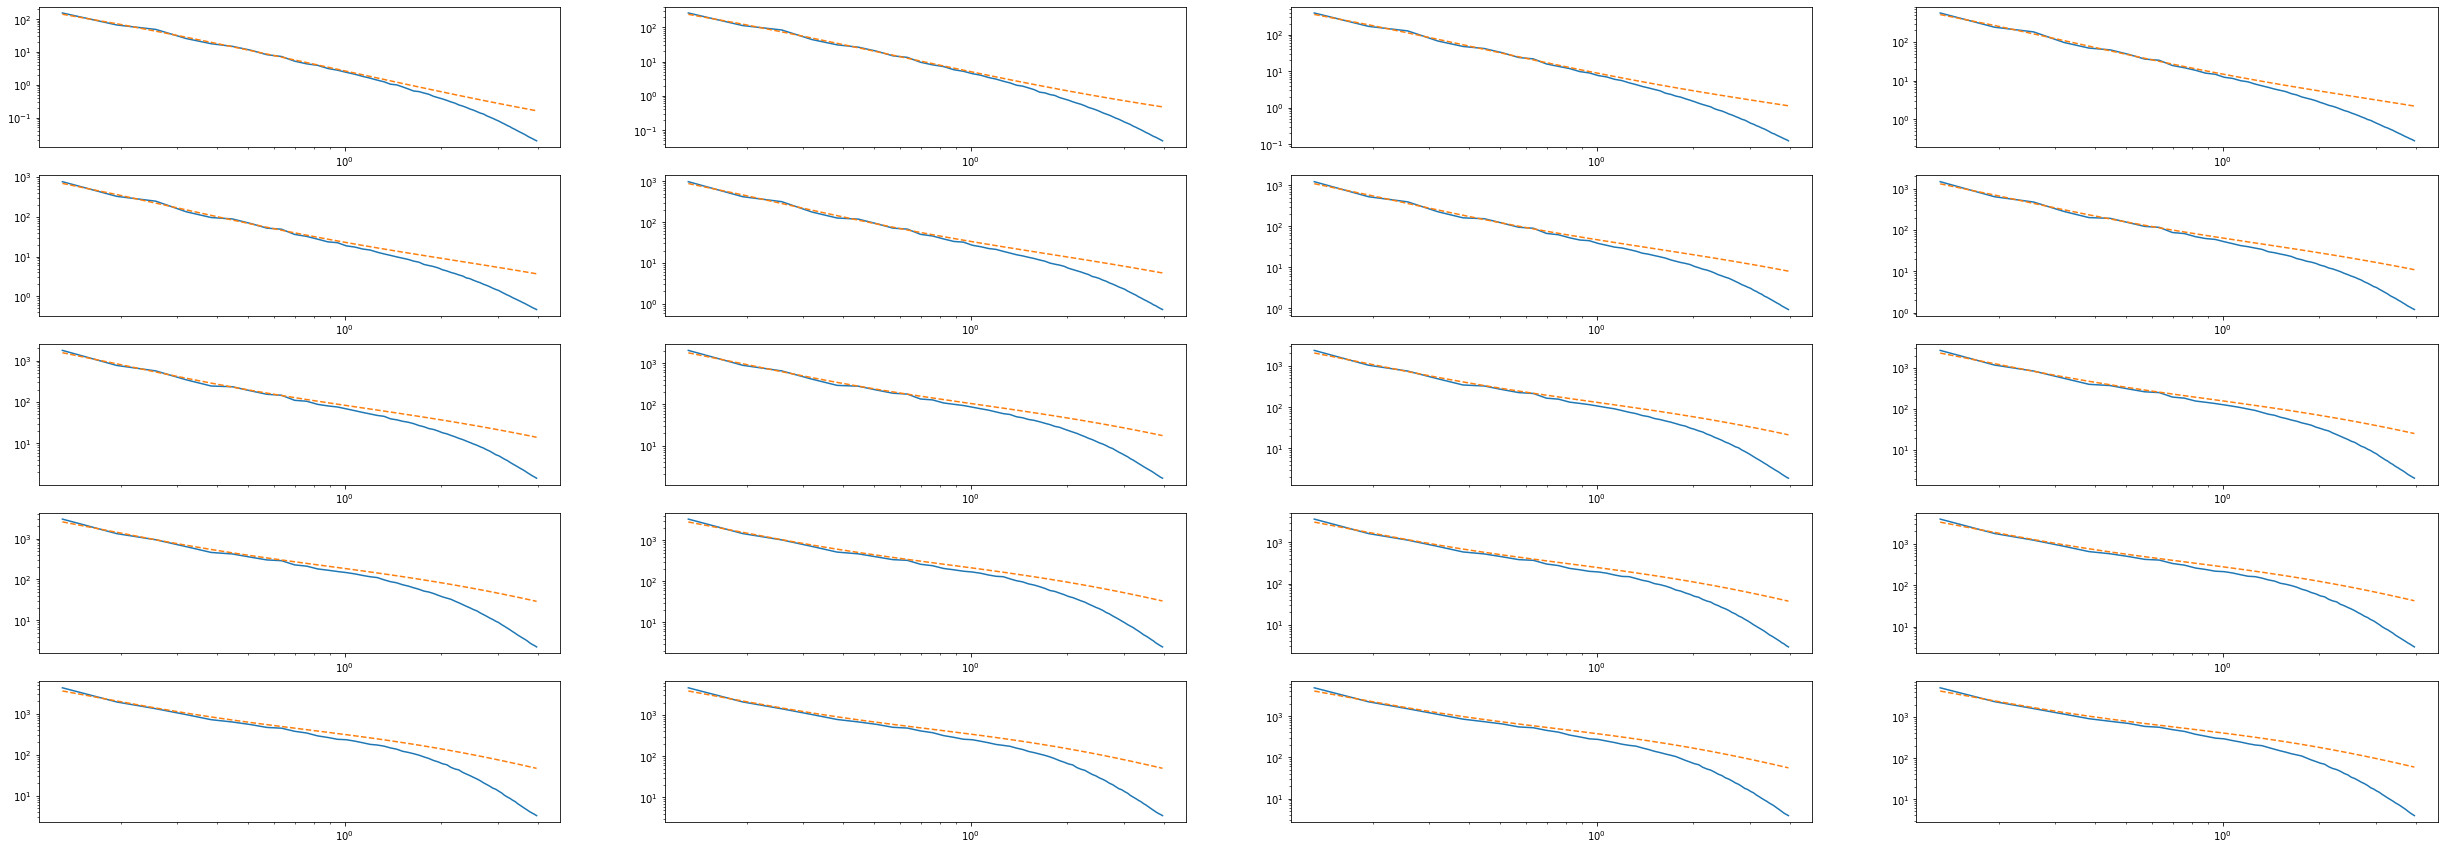

In [132]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(43, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, p in zip(axs.flat, pk_array):
    ax.loglog(k, p,label='Differentiable Simulation ')
for ax, pj in zip(axs.flat, pk_jax):
    ax.loglog(k, pj,'--',label='Jax-cosmo linear')
plt.show()